# Principal Component Analysis

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Explained Variance and Lossy Reconstruction

#### The Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#### Sampling 1000 images from either of them

In [4]:
num_samples_per_class = 100
selected_indices = []

targets = train_dataset.targets.numpy()

for digit in np.unique(targets):
    digit_indices = np.where(targets == digit)[0]
    sampled_indices = np.random.choice(digit_indices, num_samples_per_class, replace=False)
    selected_indices.extend(sampled_indices)

np.random.shuffle(selected_indices)

sampled_data = []
for i in selected_indices:
    sampled_data.append(train_dataset[i])

sampled_counts = Counter([label for _, label in sampled_data])
print("Sampled images per class:", sampled_counts)

Sampled images per class: Counter({0: 100, 5: 100, 6: 100, 8: 100, 3: 100, 7: 100, 1: 100, 4: 100, 9: 100, 2: 100})


#### PCA from Scratch

In [5]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[sorted_idx]
        self.components = eigenvectors[:, sorted_idx]
        self.components = self.components[:, :self.n_components]
        return self

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

X = np.array([img.numpy() for img, label in sampled_data])
print("Original dimension:", X.shape)
dims = [500, 300, 150, 30]
projections = {}

for d in dims:
    pca_model = PCA(n_components=d)
    projections[d] = pca_model.fit_transform(X)
    print(f"Projection to {d} dimensions shape:", projections[d].shape)

Original dimension: (1000, 784)
Projection to 500 dimensions shape: (1000, 500)
Projection to 300 dimensions shape: (1000, 300)
Projection to 150 dimensions shape: (1000, 150)
Projection to 30 dimensions shape: (1000, 30)


#### Plot of explained variance vs. the number of principal components.

And

#### Visualize the samples using the first 2 PCs (using a scatter plot) and write your observations.

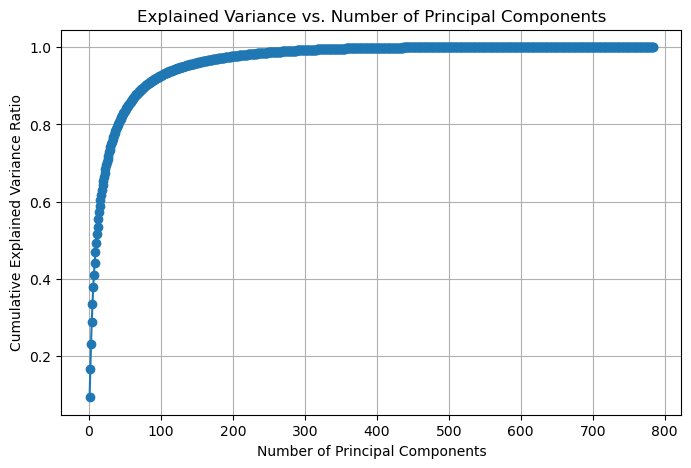

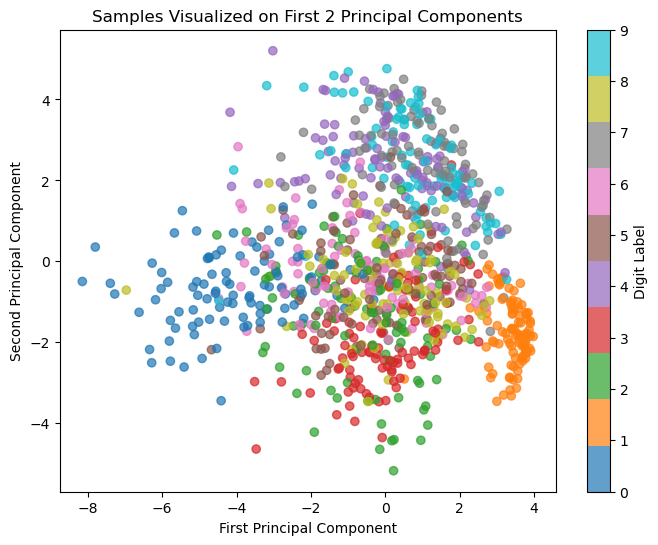

In [6]:
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)
eigenvalues, _ = np.linalg.eigh(cov_matrix)
eigenvalues = np.sort(eigenvalues)[::-1]

explained_variance_ratio = eigenvalues / eigenvalues.sum()
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(eigenvalues) + 1), cumulative_explained_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid(True)
plt.show()

pca_2 = PCA(n_components=2)
X_pca2 = pca_2.fit_transform(X)

labels = np.array([label for (_, label) in sampled_data])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Samples Visualized on First 2 Principal Components")
plt.colorbar(scatter, ticks=range(10), label="Digit Label")
plt.show()


#### Observations:
1. The cumulative explained variance graph shows a steep increase in variance explained by the first few components, indicating that most of the variance in the data is captured in a lower-dimensional subspace.
2. The scatter plot using the first 2 PCs reveals clustering according to digit labels, although some overlap exists, suggesting that while the 2D projection provides insight into separability, additional components may be needed for clearer distinctions.

#### Now, select any 5 images from these samples. Plot them before dimensionality reduction, and after projecting them back to the original space (do this for every type of final dimensions value). Write your observations.

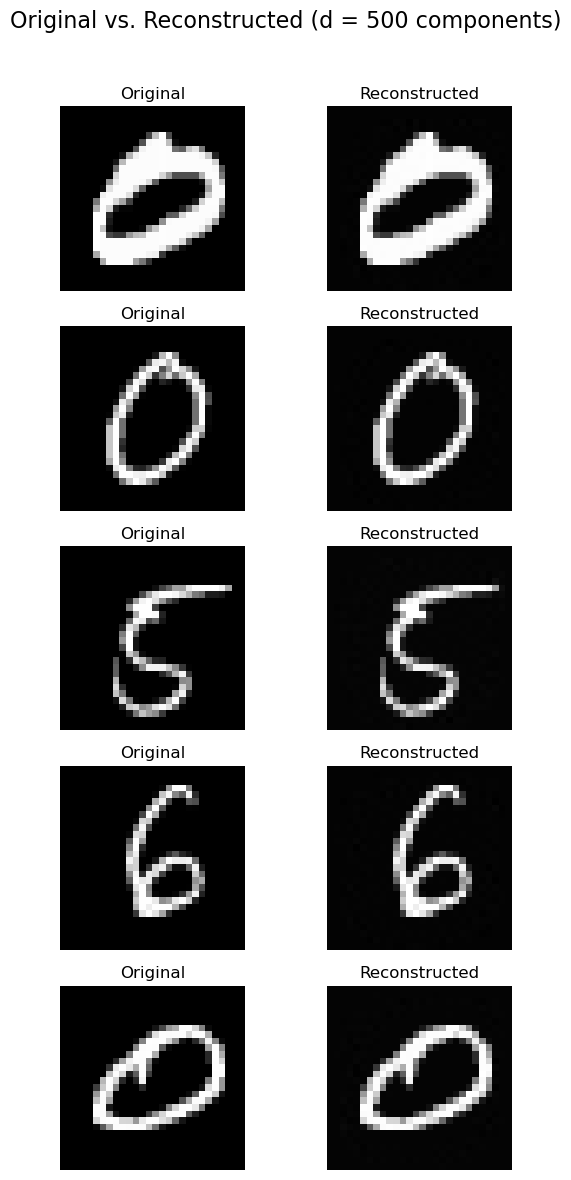

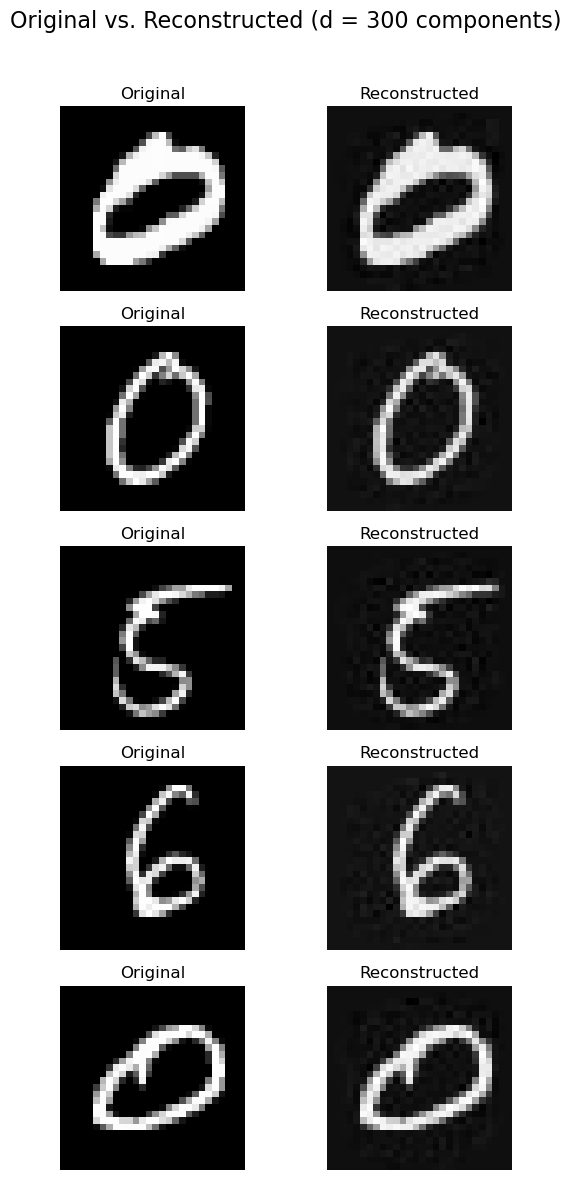

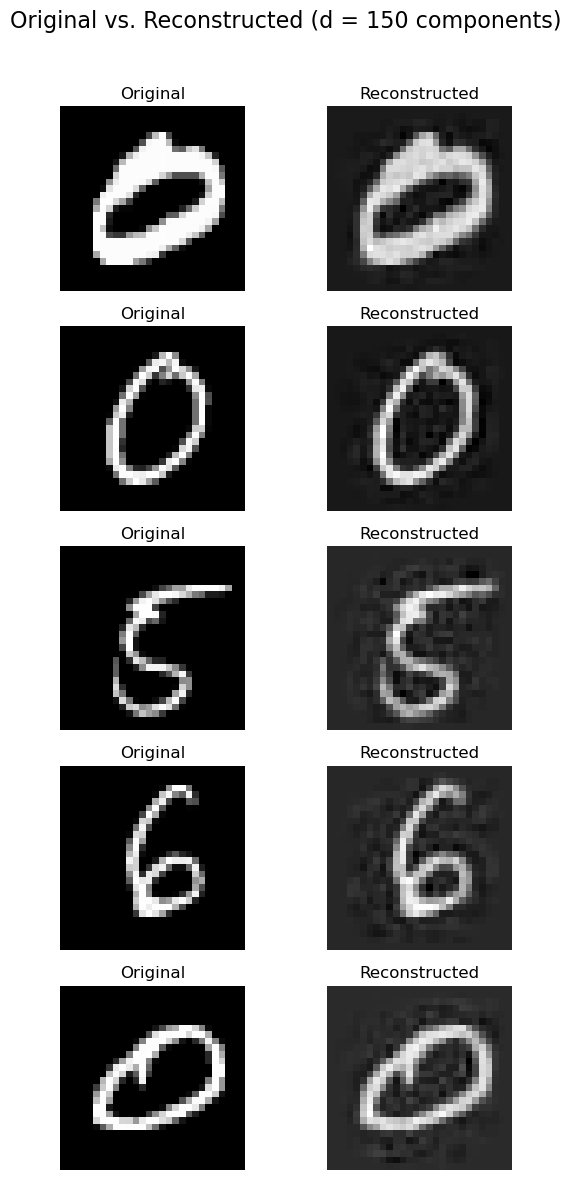

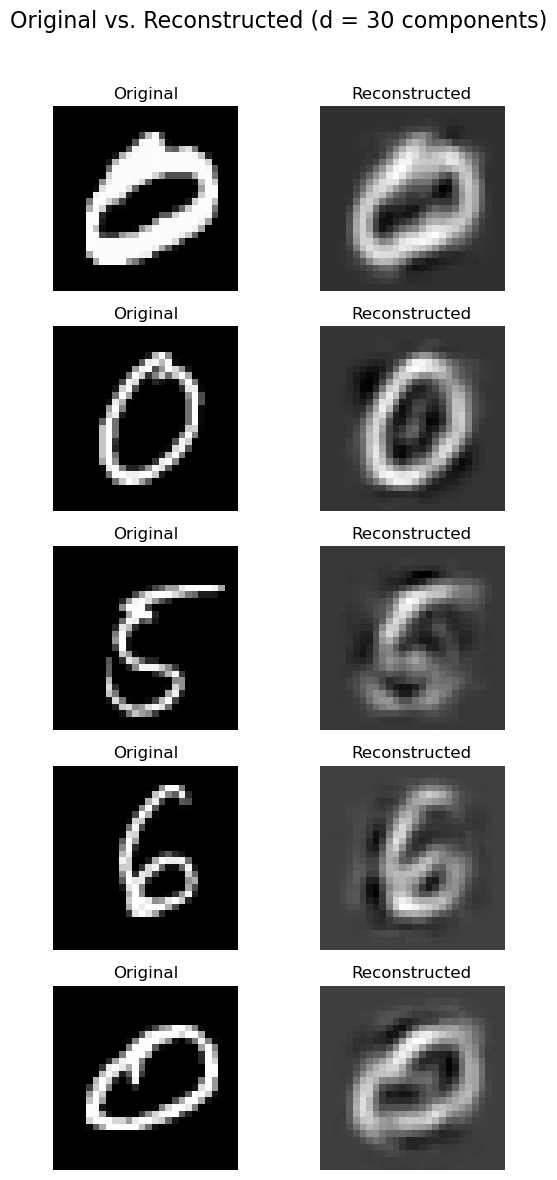

In [7]:
sample_ids = [0, 1, 2, 3, 4]

dims_list = [500, 300, 150, 30]

for d in dims_list:
    pca_model = PCA(n_components=d)
    X_proj = pca_model.fit_transform(X)
    X_reconstructed = np.dot(X_proj, pca_model.components.T) + pca_model.mean
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(6, 12))
    fig.suptitle(f"Original vs. Reconstructed (d = {d} components)", fontsize=16)
    
    for i, idx in enumerate(sample_ids):
        orig_img = X[idx].reshape(28, 28)
        rec_img = X_reconstructed[idx].reshape(28, 28)
        
        axes[i, 0].imshow(orig_img, cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(rec_img, cmap='gray')
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


#### Observations:
- When using a large number of components (e.g., 500), the reconstructed images closely resemble the originals, retaining fine details.
- As the component count decreases (e.g., 300, 150, and eventually 30), noticeable detail loss occurs.
- At very low dimensions (e.g., 30), the reconstructed images become blurry and lack contrast, suggesting that significant variance—and therefore important image details—is not retained.

### Classification Performance with vs without dimensionality reduction

In [8]:
train_indices_subset = np.random.choice(len(train_dataset), size=40000, replace=False)
train_samples = [train_dataset[i] for i in train_indices_subset]
X_train = np.stack([sample[0].numpy() for sample in train_samples])
y_train = np.array([sample[1] for sample in train_samples])

test_samples = [test_dataset[i] for i in range(len(test_dataset))]
X_test = np.stack([sample[0].numpy() for sample in test_samples])
y_test = np.array([sample[1] for sample in test_samples])

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9754
Precision: 0.9754927757890053
Recall: 0.9751627839667106


/home/anshium/miniconda3/envs/smai/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Now, perform dimensionality reduction on the train and test sets. Train a new MLP model for classification with the new train set and report the above metrics for the new test set.

In [9]:
pca_d = 150
pca_model = PCA(n_components=pca_d)

X_train_reduced = pca_model.fit_transform(X_train)
X_test_reduced = pca_model.transform(X_test)

mlp_reduced = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
mlp_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = mlp_reduced.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred_reduced)
precision = precision_score(y_test, y_pred_reduced, average="macro")
recall = recall_score(y_test, y_pred_reduced, average="macro")

print("Original Dimension:", X_train.shape[1])
print("Reduced Dimension:", pca_d)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Original Dimension: 784
Reduced Dimension: 150
Accuracy: 0.9732
Precision: 0.9730063144986263
Recall: 0.9729275411152315


/home/anshium/miniconda3/envs/smai/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Perform PCA for the above by taking dimensions = 500, 300, 150 and 3 (each separately). Write your observations from the performance in each case.

In [10]:
dims = [500, 300, 150, 30]

for d in dims:
    pca_model = PCA(n_components=d)
    X_train_reduced = pca_model.fit_transform(X_train)
    X_test_reduced = pca_model.transform(X_test)
    
    mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
    mlp_model.fit(X_train_reduced, y_train)
    
    y_pred_reduced = mlp_model.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred_reduced)
    prec = precision_score(y_test, y_pred_reduced, average="macro")
    rec = recall_score(y_test, y_pred_reduced, average="macro")
    
    print(f"PCA Dimension: {d}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("-" * 40)


/home/anshium/miniconda3/envs/smai/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


PCA Dimension: 500
Accuracy: 0.9679
Precision: 0.9677
Recall: 0.9676
----------------------------------------


/home/anshium/miniconda3/envs/smai/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


PCA Dimension: 300
Accuracy: 0.9699
Precision: 0.9697
Recall: 0.9696
----------------------------------------


/home/anshium/miniconda3/envs/smai/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


PCA Dimension: 150
Accuracy: 0.9732
Precision: 0.9730
Recall: 0.9729
----------------------------------------
PCA Dimension: 30
Accuracy: 0.9757
Precision: 0.9755
Recall: 0.9754
----------------------------------------


/home/anshium/miniconda3/envs/smai/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Observation :
1. For lower dimensions all three metrics, accuracy, precision and recall are higher as compared to the higher dimensions.
2. A possible reason for this can be in higher dimensions, the MLP learns the weights according to the less significant eigen values also, which results in less accuracy for higher dimension data. In simpler words, the unnecessary eigen vectors also affect the weights of the model.

### Report

#### We know from the Previous Plots:
- The cumulative explained variance plot showed that the first few principal components capture most of the total variance.
- A scatter plot of MNIST samples on the first two principal components revealed clustering by digit labels, demonstrating PCA’s ability to uncover structure despite some overlap.
- Comparing original and reconstructed images with different numbers of principal components illustrated the trade-off between dimensionality reduction and reconstruction quality—too few components (e.g., 30) led to noticeable information loss.

#### How PCA Mitigates the Curse of Dimensionality

The curse of dimensionality refers to the challenges that arise when working with high-dimensional data, such as increased computational cost, sparsity, and overfitting. PCA (Principal Component Analysis) helps mitigate these issues in the following ways:

1. Dimensionality Reduction – PCA projects the data onto a lower-dimensional subspace while preserving as much variance as possible. This helps eliminate redundant features, making computations more efficient.

2. Noise Reduction – High-dimensional data often contains noise. PCA can filter out noise by discarding lower-variance components that are likely less informative.

3. Improved Generalization – Reducing dimensions prevents models from overfitting by removing irrelevant features, thus improving generalization to new data.

#### Cases Where PCA Might Not Be Effective

Despite its advantages, PCA is not always effective in high-dimensional spaces. Some cases where it may fail include:

1. Nonlinear Data Structures – PCA assumes linear relationships among features. If the data follows a nonlinear manifold, PCA may fail to capture meaningful structure. Nonlinear methods like t-SNE or kernel PCA may be better alternatives.
 
2. Low Variance but Important Features – PCA discards low-variance components, assuming they are unimportant. However, in some cases (e.g., fraud detection), small variations in certain features may be crucial.

3. Highly Correlated Features – If most features are highly correlated, PCA may not significantly reduce dimensionality, as the top principal components may still retain a large number of dimensions.

#### When PCA’s Variance Assumption Fails

PCA assumes that directions with the highest variance carry the most information. However, this is not always true.

Example: Handwritten Digit Recognition

In image classification tasks (e.g., recognizing digits from the MNIST dataset), the most important information may lie in small structural details rather than overall pixel variance. A low-variance direction might capture subtle but crucial distinctions between digits (e.g., differentiating between "3" and "8"). If PCA removes these components, it could degrade classification performance.